In [1]:
from __future__ import division

In [2]:
%matplotlib inline

#### libraries and functions

https://github.com/juhuntenburg/brainsurfacescripts

In [3]:
import gdist
import numpy as np
import pandas as pd
from pqdict import PQDict
#from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh, dijkstra, shortest_path, sorted_path
from plotting import plot_surf_stat_map

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [64]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### Read and convert data

In [4]:
mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy'
embed_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/smooth_3/mask_025_5/rh_embed_10.npy'
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/avg_rh_profiles.npy'
path_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_lateral_path.1D.roi'

#mesh_file = '/SCR/data/ohbm2016/lowres_rh_d.vtk'
#sulc_file = '/SCR/data/ohbm2016/lowres_rh_sulc.npy'
#embed_file = '/SCR/data/ohbm2016/mask_025_5/rh_embed_10.npy'
#t1_file = '/SCR/data/ohbm2016/avg_rh_profiles.npy'

In [5]:
v,f,d=read_vtk(mesh_file)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)
sulc = np.load(sulc_file)
profiles = np.load(t1_file)
embed = np.load(embed_file)
unsorted_path = np.loadtxt(path_file, dtype='int64')[:,0]

In [6]:
G=graph_from_mesh(vertices, faces, edge_length=True)

### Create path and windows

The graph representation of the surface is used to find the shortest path between the chosen source and target node. For each node on the path a window is created containing all other nodes that lie within a given radius and are closer to this node that to any other node on the path. These single node windows are then combined into a larger window with the chosen width that is sliding along the path.

In [7]:
#source=46644
#target=59276
#path=shortest_path(G,source,target)
#path=list(np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_4664_59276.npy'))
#np.save('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_4664_59276.npy', np.asarray(path))
path = sorted_path(G, unsorted_path)

In [8]:
radius=3
halfwidth=1 # combined window size will be 2*halfwidth single windows
overlap=0 # in single windows

In [9]:
# for each vertex show only those vertices in the sparse matrix, that have a distance < radius
# for these give the precise distance
inradius_matrix=gdist.local_gdist_matrix(vertices, faces, max_distance=radius)

In [10]:
# get only the vertices that are in a distance < radius to any node in path
inradius_path=[]
for pnode in path:
    inradius_path=list(np.unique(inradius_matrix[:,path].indices))

In [11]:
# make an array with the radius neighbours in columns and the path nodes in rows
path_x_neighbours=np.zeros((len(inradius_path), len(path)))
for pnode in range(len(path)):
    path_x_neighbours[:,pnode]=np.reshape(inradius_matrix[inradius_path,path[pnode]].toarray(),
                                          (len(inradius_path),))
path_x_neighbours[path_x_neighbours==0]=np.nan

In [12]:
# for each vertex in this list, find the node on path it is closest to
path_x_neighbours_min=np.zeros((len(inradius_path),1))
for nnode in range(len(inradius_path)):
    path_x_neighbours_min[nnode]=np.nanargmin(path_x_neighbours[nnode,:])

In [13]:
#for each node on the path, extract those neighbour nodes, that fall into its window
windows=[]
for pnode in range(len(path)):
    window=[path[pnode]]
    indices = [i for i, x in enumerate(list(path_x_neighbours_min)) if x == pnode]
    [window.append(inradius_path[y]) for y in indices]
    windows.append(window)

In [14]:
# combine single windows for sliding, some nodes at the end of the path might be dropped to ensure equal sized windows
combined_windows=[]
for window in np.arange(start=halfwidth, stop=len(windows)-halfwidth, step=2*halfwidth-overlap):
    combined_window=[]
    for k in range(window-halfwidth,window+halfwidth):
        combined_window+=windows[k]
    combined_windows.append(combined_window)

### Sample profiles in windows

In [15]:
profiles = profiles[:,3:8]

In [16]:
# sample t1 per window, calc mean profile and sdv
profile_windows=[]
profile_avg=[]
profile_sdv=[]
for window in combined_windows:
    profile_windows.append(profiles[window])
    profile_avg.append(np.mean(profiles[window], axis=0))
    profile_sdv.append(np.std(profiles[window], axis=0))

In [71]:
# calculate chebychev coefficients for all the profiles in the windows, as well as mean chebychev per window
cheb_windows=[]
cheb_avg=[]
for window in combined_windows:
    coeff, poly = chebapprox(profiles[window], degree=4)
    cheb_windows.append(coeff)
    cheb_avg.append(np.mean(coeff, axis=0))

### Plotting

#### Functional connectivity embedding

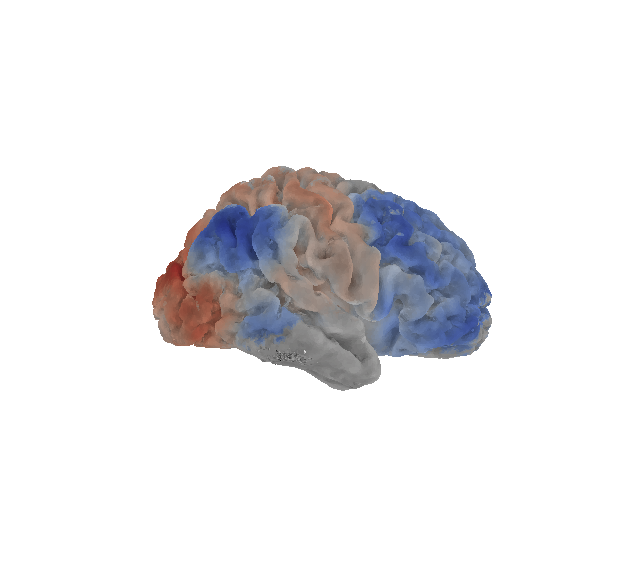

In [17]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=embed[:,0],
                        bg_map=sulc, bg_on_stat=True,
                        elev=180, azim=0,
                        #elev=200,azim=20,
                        #cmap='jet',
                        figsize=(11,10))

#### Path

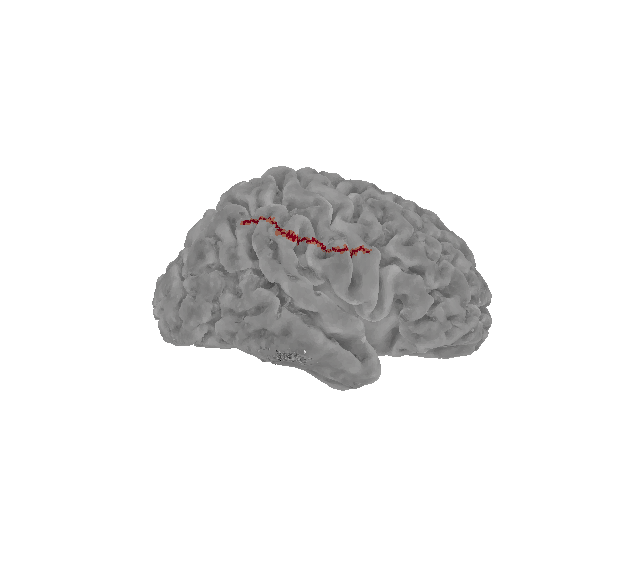

In [18]:
sns.set_style('white')
pathbrain = np.zeros_like(vertices[:,0])
pathbrain[path] = 1
plot=plot_surf_stat_map(vertices, faces, stat_map=pathbrain, bg_map=sulc, bg_on_stat=True, elev=180,azim=0, figsize=(11,10))

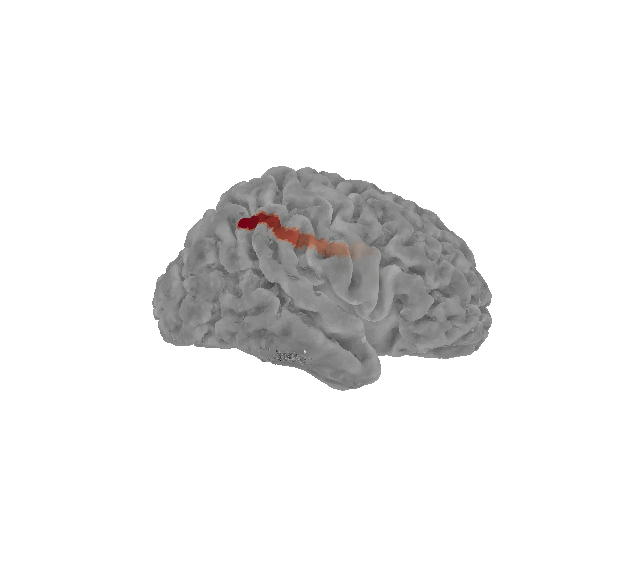

In [19]:
allwindow_surf=np.zeros((len(vertices),))
for window in range(len(windows)):
    allwindow_surf[windows[window]]=window+10
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=allwindow_surf, bg_map=sulc, bg_on_stat=True, 
                        elev=180,azim=0, figsize=(11,10))

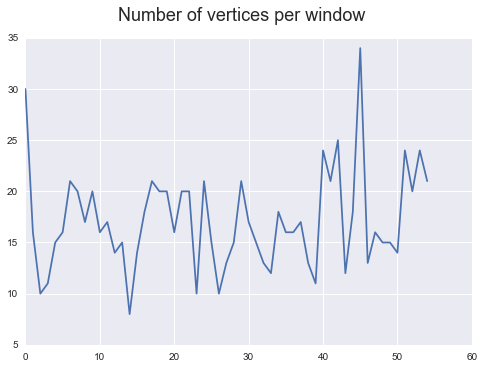

In [20]:
wsize=[]
for window in combined_windows:
    wsize.append(len(window))
sns.set_style('darkgrid')
fig = plt.figure()
plt.plot(wsize)
fig.suptitle('Number of vertices per window', fontsize=18)

In [21]:
window_surfs=[]
for combined_window in range(len(combined_windows)):
    window_surf=np.zeros((len(vertices),))
    for j in path:
        window_surf[j]=-10
    for i in combined_windows[combined_window]:
        window_surf[i]=10
    window_surfs.append(window_surf)

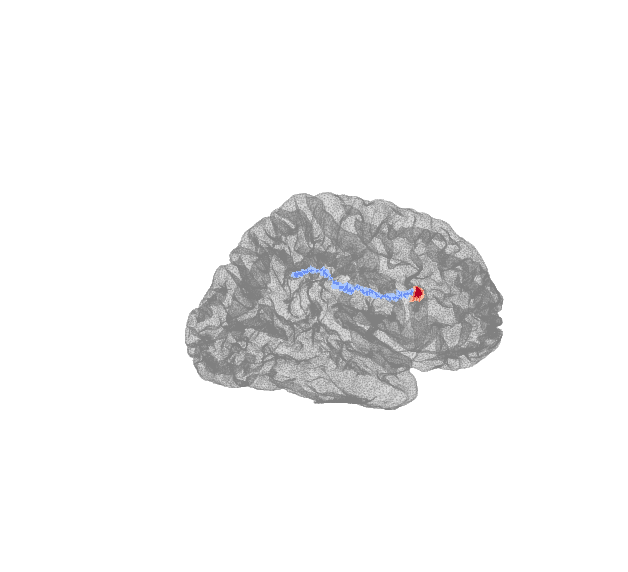

In [22]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[0], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

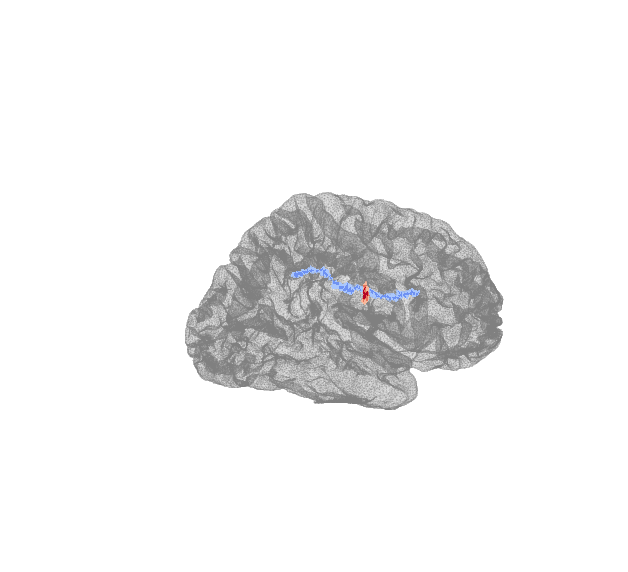

In [23]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[int(len(window_surfs)/2)], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

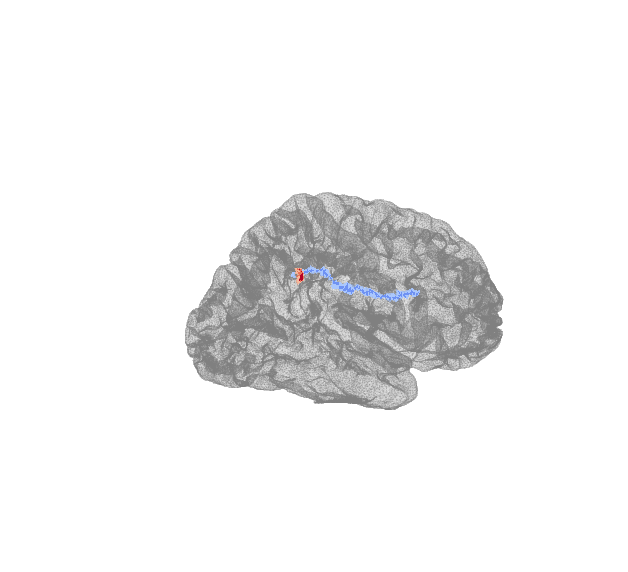

In [24]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[-1], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

#### T1 profiles in windows

In [25]:
sns.set_style('darkgrid')
colors = sns.color_palette('cubehelix', 10)

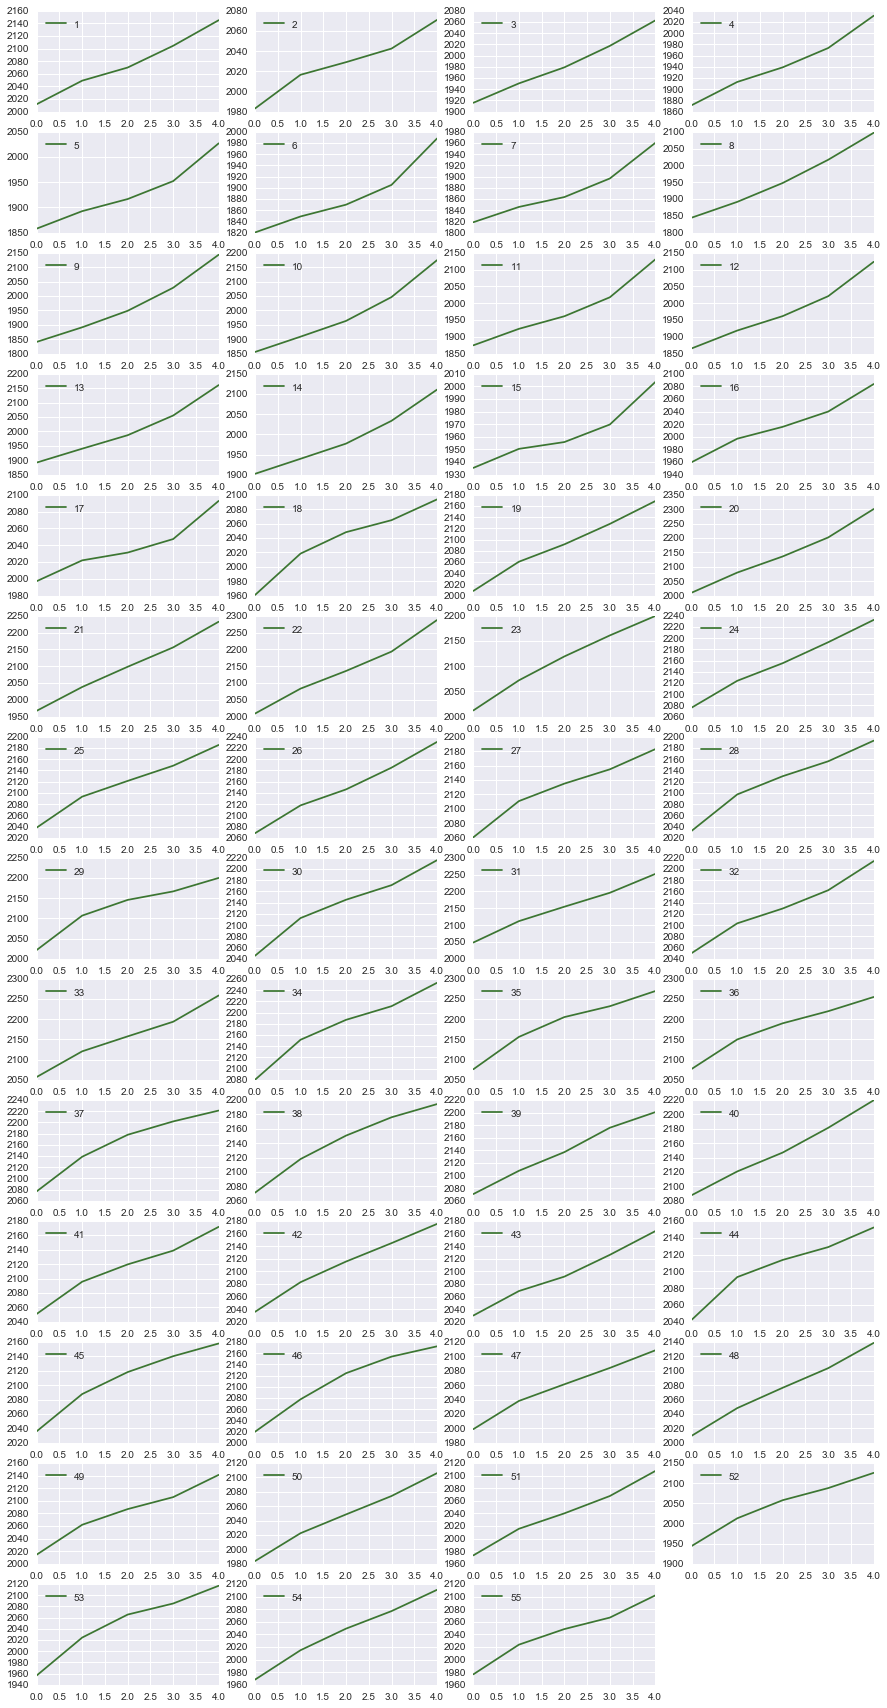

In [26]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    plt.plot(profile_avg[i], label=str(i+1), color=colors[3])
    plt.legend(loc=2)

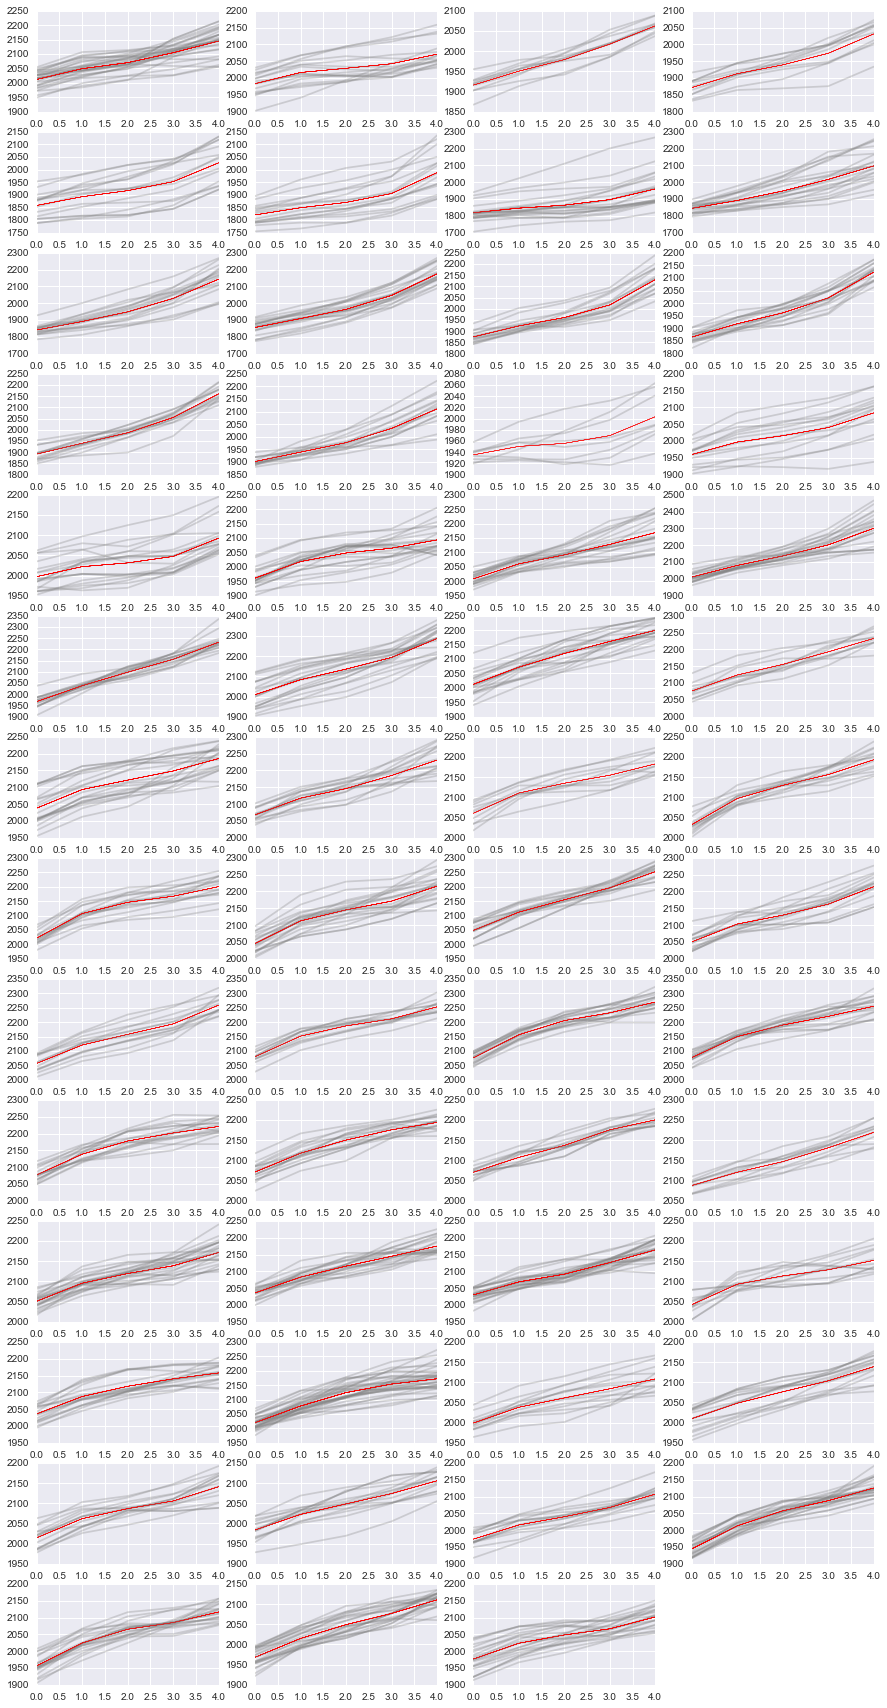

In [30]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    for pro in range(len(profile_windows[i])):
        plt.plot(profile_windows[i][pro],color='gray', alpha=0.3)
        plt.plot(profile_avg[i], color='red', linewidth=0.2)

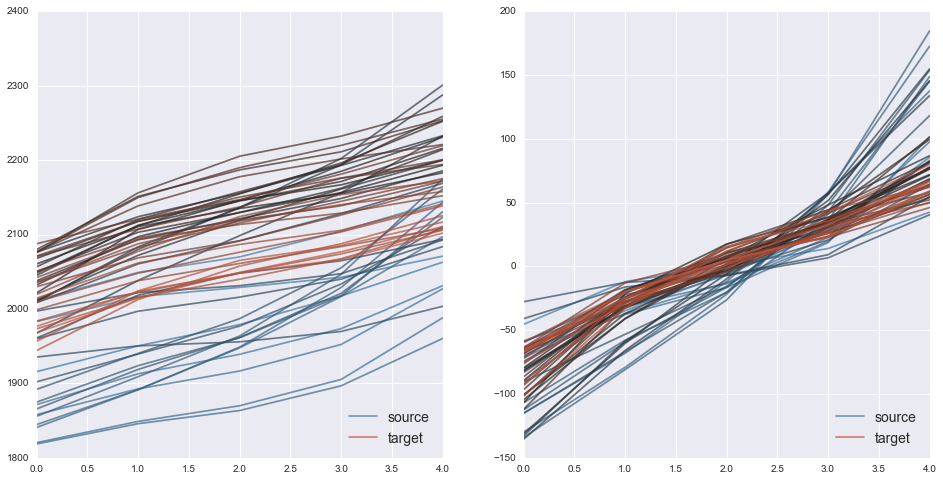

In [63]:
etamap=np.array(sns.diverging_palette(240, 20, n=len(profile_avg), center='dark'))
alpha=0.7
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
for i in range(len(profile_avg)):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(profile_avg[i], color=(r,g,b),label='source', alpha=alpha)
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i], color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(profile_avg[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)


fig.add_subplot(122)
for i in range(len(profile_avg)):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b),label='source', alpha=alpha)
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)

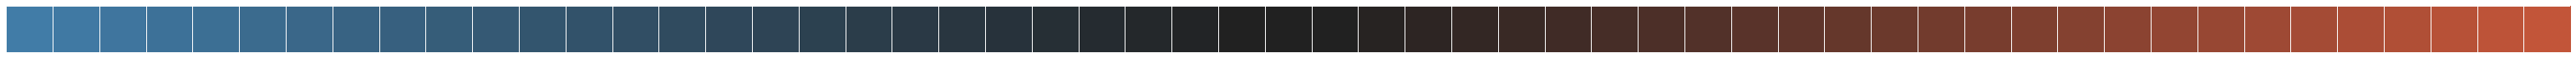

In [58]:
sns.palplot(etamap)

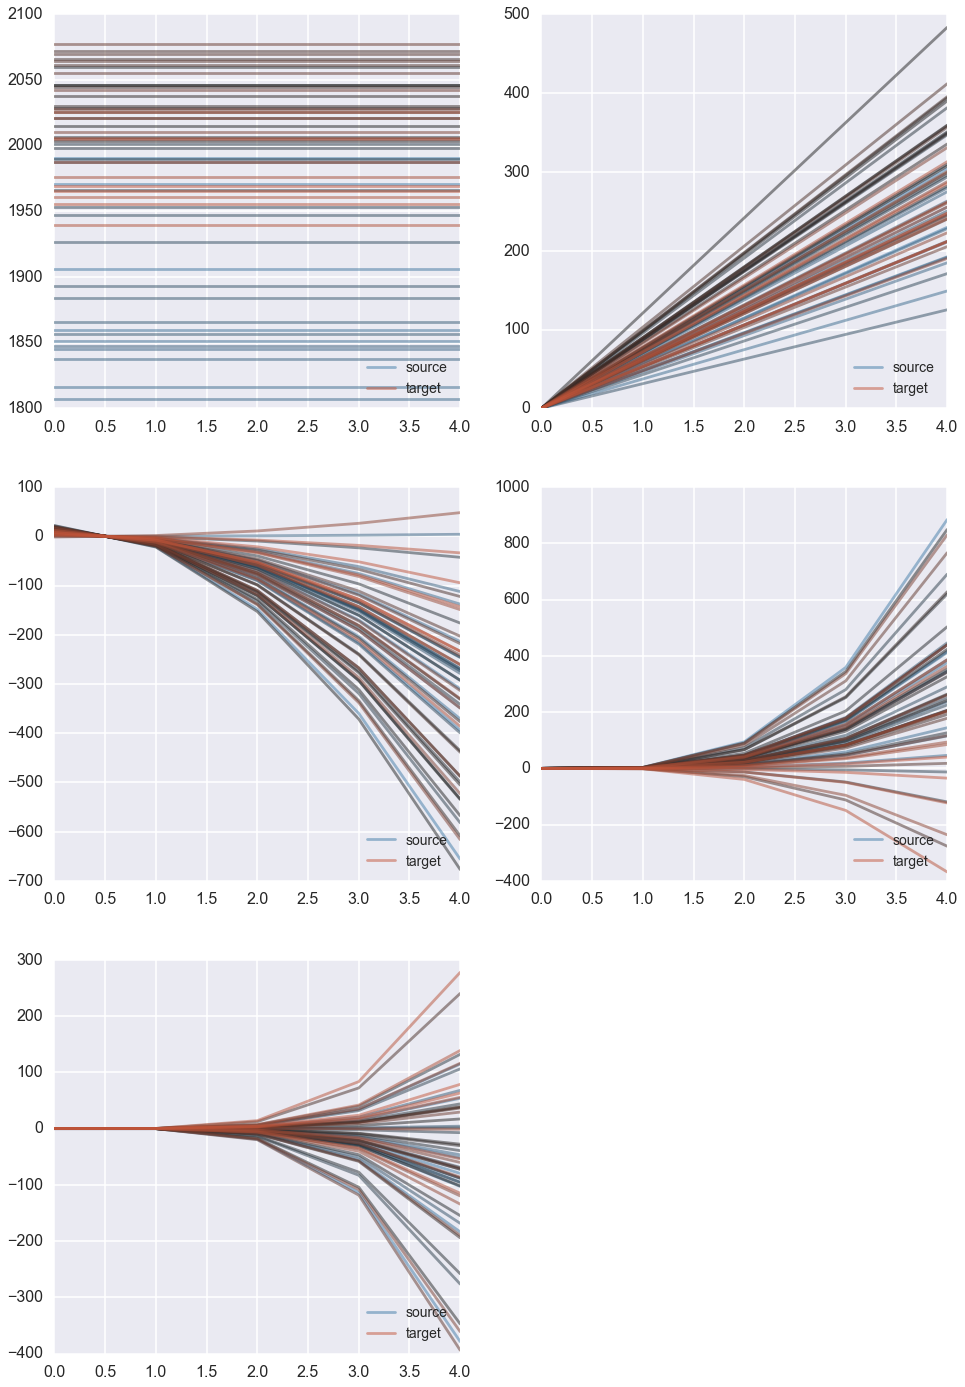

In [166]:
alpha=0.5
x = np.arange(len(cheb_windows[0][0]))
fig = plt.figure(figsize=(16,24))

fig.add_subplot(321)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [cheb_avg[w][0]])
    
for i in range(cheb_avg_plot.shape[0]):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='source', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)



fig.add_subplot(322)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,cheb_avg[w][1]])

for i in range(cheb_avg_plot.shape[0]):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='source', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)



fig.add_subplot(323)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,cheb_avg[w][2]])

for i in range(cheb_avg_plot.shape[0]):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='source', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)




fig.add_subplot(324)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,cheb_avg[w][3]])

for i in range(cheb_avg_plot.shape[0]):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='source', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)




fig.add_subplot(325)
cheb_avg_plot = np.zeros((len(cheb_avg),len(cheb_windows[0][0])))
for w in range(len(cheb_avg)):
    cheb_avg_plot[w] = np.polynomial.chebyshev.chebval(x, [0,0,0,0,cheb_avg[w][4]])

for i in range(cheb_avg_plot.shape[0]):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='source', alpha=alpha)
    elif i==len(cheb_avg)-1:
        plt.plot(cheb_avg_plot[i], color=(r,g,b),label='target', alpha=alpha)
    else:
        plt.plot(cheb_avg_plot[i], color=(r,g,b), alpha=alpha)
plt.legend(loc=4, fontsize=14)

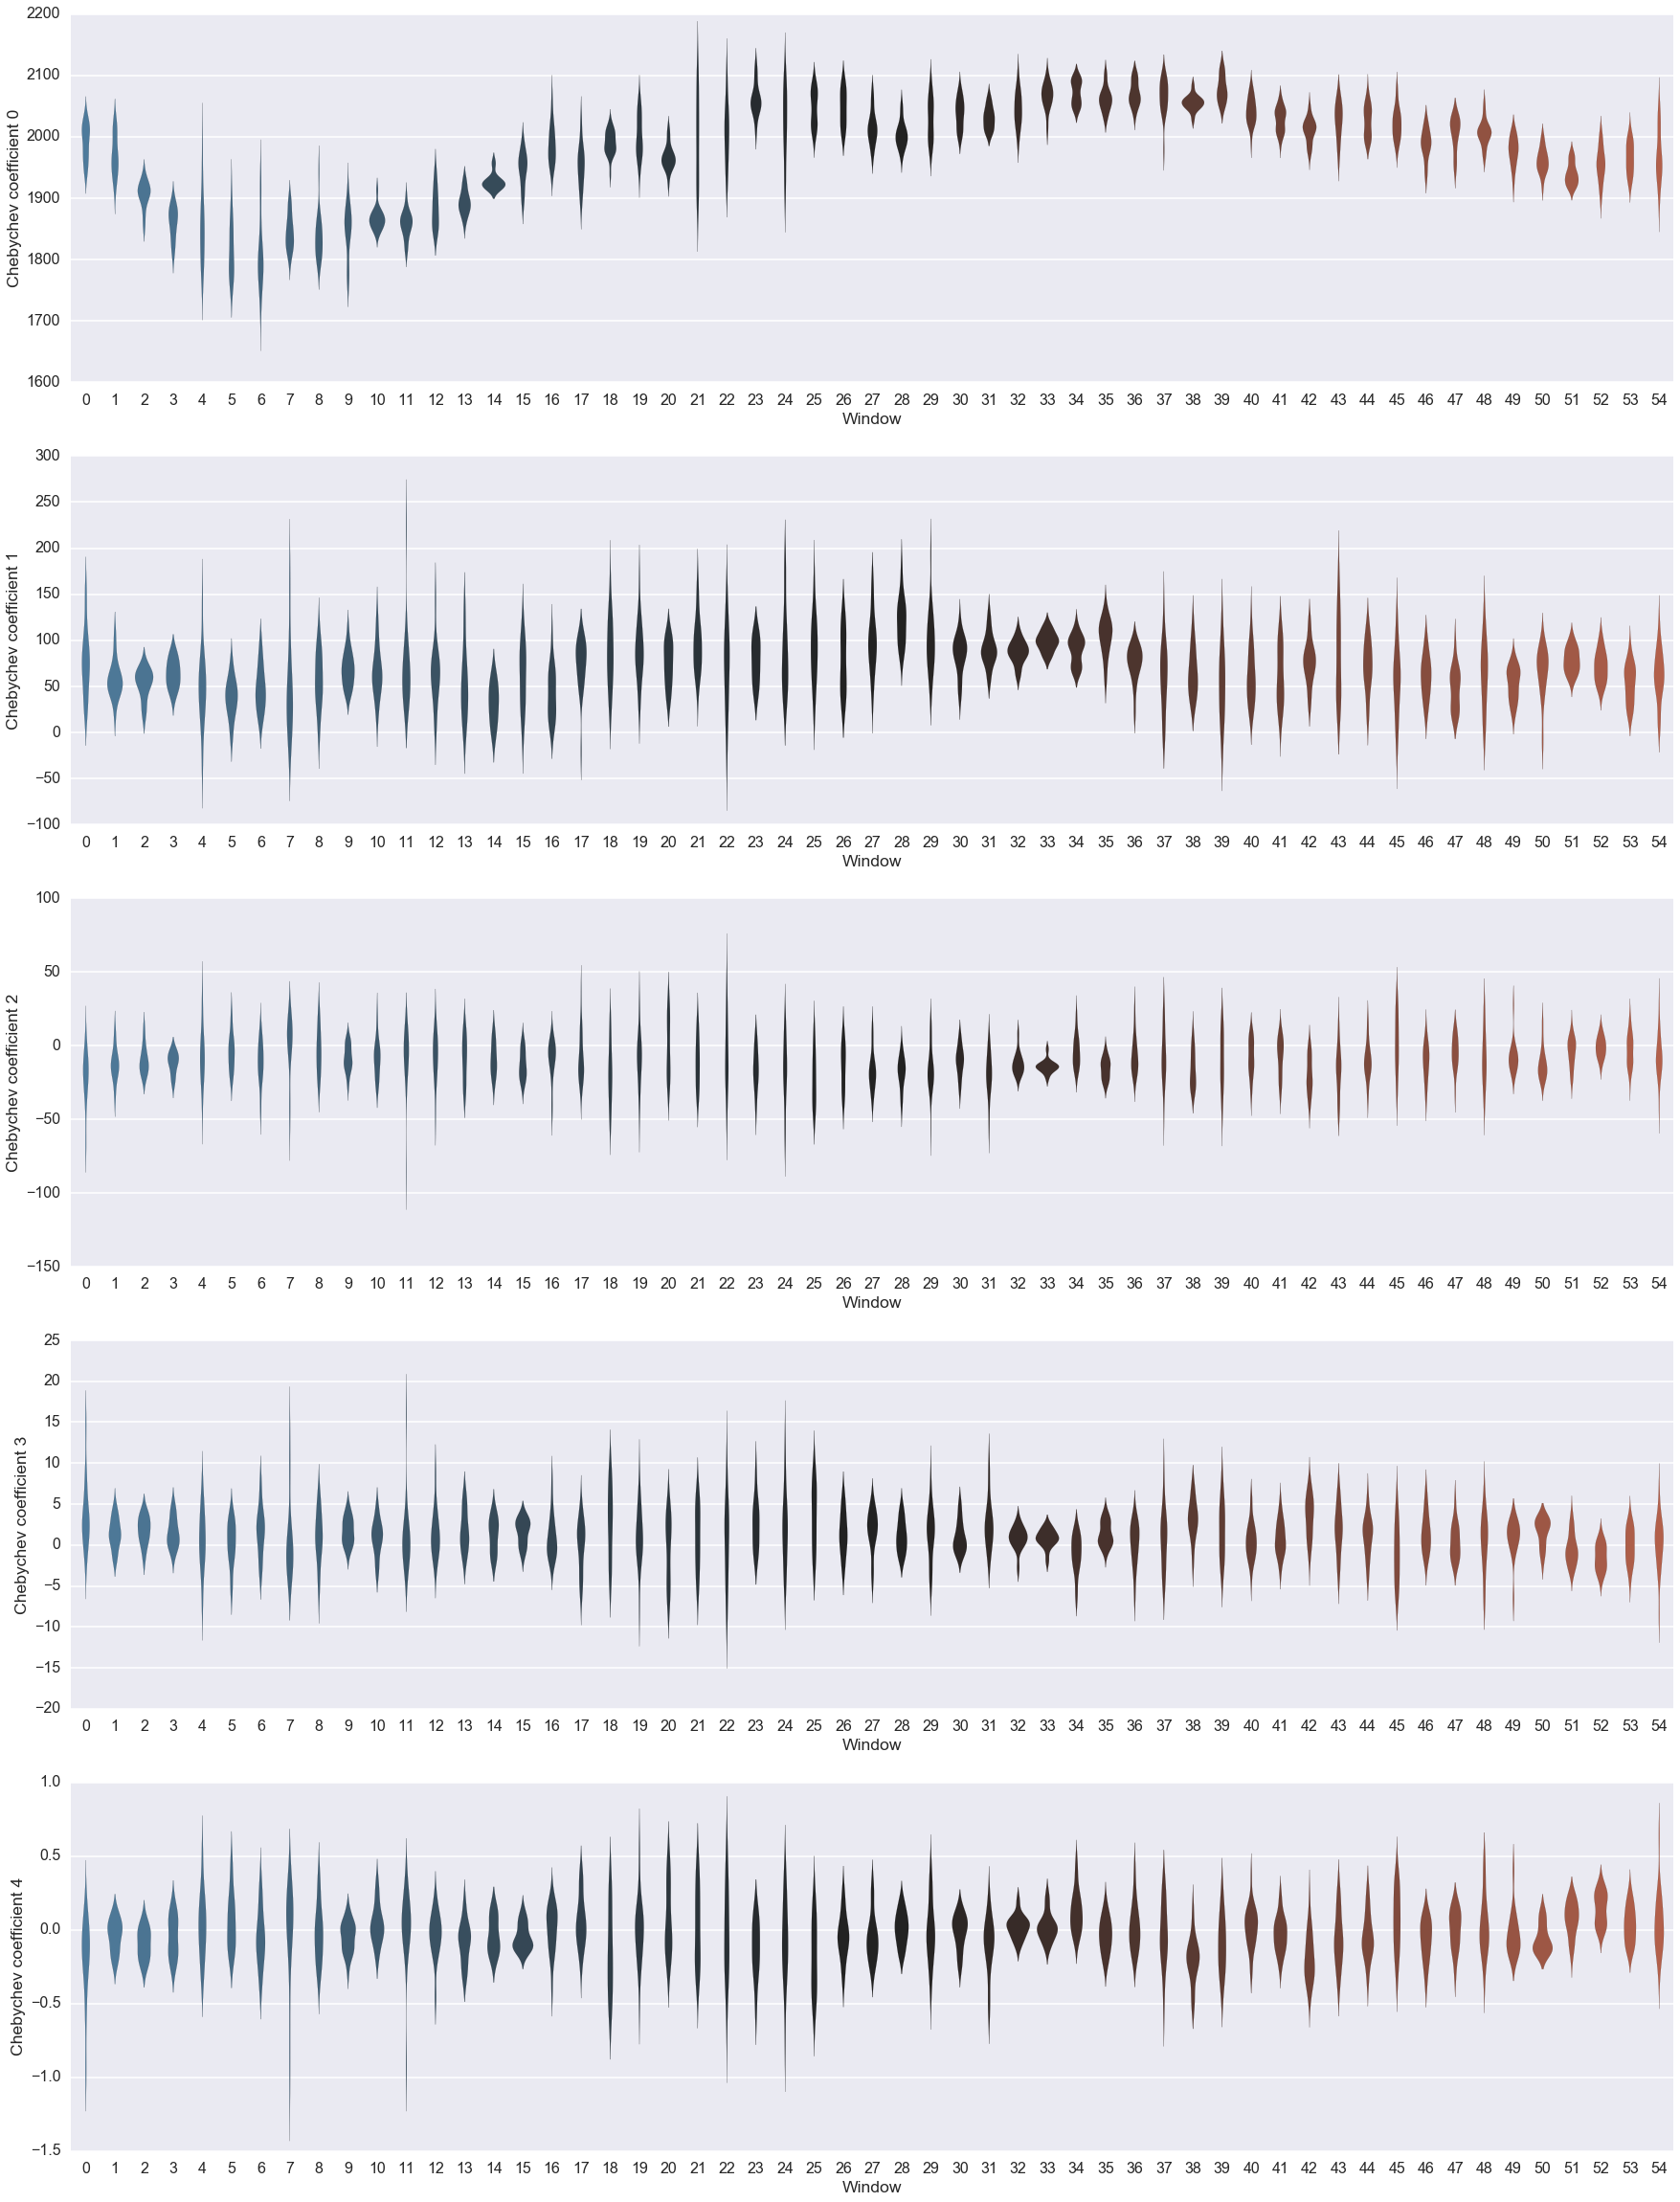

In [117]:
sns.set_context('poster')

fig = plt.figure(figsize=(30,40))

fig.add_subplot(511)
no_coeff = 0
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=etamap, 
                    inner=None, linewidth=0.1)


fig.add_subplot(512)
no_coeff = 1
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=etamap, 
                    inner=None, linewidth=0.1)


fig.add_subplot(513)
no_coeff = 2
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=etamap, 
                    inner=None, linewidth=0.1)



fig.add_subplot(514)
no_coeff = 3
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=etamap, 
                    inner=None, linewidth=0.1)




fig.add_subplot(515)
no_coeff = 4
plot_list=[]
window_list=[]
for i in range(len(cheb_windows)):
    for j in range(len(cheb_windows[i])):
        plot_list.append(cheb_windows[i][j,no_coeff])
        window_list.append(i)
    
plot_df=pd.DataFrame(columns=['Chebychev coefficient %i'%no_coeff, 'Window'])
plot_df['Chebychev coefficient %i'%no_coeff]=plot_list
plot_df['Window']=window_list

ax = sns.violinplot(x="Window", y='Chebychev coefficient %i'%no_coeff, data=plot_df, palette=etamap, 
                    inner=None, linewidth=0.1)